In [38]:
import pandas as pd
import sklearn as skl
from sklearn import *
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

In [40]:
pd.set_option('max_columns', 30)
fulldata = pd.read_csv('data.csv');
fulldata.head(4)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4


In [41]:
fulldata['matchup'] = fulldata['matchup'].map(lambda x: x.split()[1])

text_columns = ['action_type', 'season', 'game_date', 'combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_name', 'matchup', 'opponent']
for col in text_columns:
    uniq_words = fulldata[col].unique()
    uniq_words = dict(enumerate(uniq_words, 1)) # 1 to enumerate from 1
    uniq_words = {v:k for k,v in uniq_words.items()}
    fulldata = fulldata.replace({col: uniq_words})
fulldata.head(4)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,1,1,10,20000012,33.9723,167,72,-118.1028,10,1,0,1,27,18,NaN,1,1,1,1,1610612747,1,1,1,1,1
1,1,1,12,20000012,34.0443,-157,0,-118.4268,10,1,0,1,22,15,0.0,1,2,1,2,1610612747,1,1,1,1,2
2,1,1,35,20000012,33.9093,-101,135,-118.3708,7,1,0,1,45,16,1.0,1,3,1,1,1610612747,1,1,1,1,3
3,1,1,43,20000012,33.8693,138,175,-118.1318,6,1,0,1,52,22,0.0,1,4,1,1,1610612747,1,1,1,1,4


In [42]:
data_test = fulldata[pd.isnull(fulldata['shot_made_flag'])]
data = fulldata[pd.notnull(fulldata['shot_made_flag'])]
data.head(4)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,1,1,12,20000012,34.0443,-157,0,-118.4268,10,1,0,1,22,15,0.0,1,2,1,2,1610612747,1,1,1,1,2
2,1,1,35,20000012,33.9093,-101,135,-118.3708,7,1,0,1,45,16,1.0,1,3,1,1,1610612747,1,1,1,1,3
3,1,1,43,20000012,33.8693,138,175,-118.1318,6,1,0,1,52,22,0.0,1,4,1,1,1610612747,1,1,1,1,4
4,2,2,155,20000012,34.0443,0,0,-118.2698,6,2,0,1,19,0,1.0,1,5,2,3,1610612747,1,1,1,1,5


In [43]:
dTrain, dTest, YTrain, YTest = model_selection.train_test_split(data.ix[:, data.columns!='shot_made_flag'], data['shot_made_flag'], test_size=0.3, random_state=1)
r_X, r_Y = data.ix[:, data.columns!='shot_made_flag'],  data['shot_made_flag']

In [74]:
XGBoost = xgb.XGBClassifier()
# xgbRegr = xgb.XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=400) #best

In [85]:
# XGBoost.fit(dTrain, YTrain)
xgbRegr.fit(r_X, r_Y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [55]:
aucXGBTrain = metrics.roc_auc_score(YTrain, XGBoost.predict_proba(dTrain)[:,1])
aucXGBTest = metrics.roc_auc_score(YTest, XGBoost.predict_proba(dTest)[:,1])
print('XGBoost:       {:6.4}  {:6.4}'.format(aucXGBTrain, aucXGBTest))
# XGBoost:       0.7344   0.702

XGBoost:       0.7342  0.7033


In [68]:
indices = [x+1 for x in data_test.index]

In [90]:
test_acc = XGBoost.predict_proba(data_test.ix[:, data_test.columns!='shot_made_flag'])[:,1]
res = list(zip(indices, test_acc))
for z in res[:3]:
    print(z)

(1, 0.4295097)
(8, 0.63073987)
(17, 0.72065878)


In [87]:
r_test_acc = xgbRegr.predict(data_test.ix[:, data_test.columns!='shot_made_flag'])
r_res = list(zip(indices, r_test_acc))
for z in r_res[:3]:
    print(z)

(1, 0.26617146)
(8, 0.30343312)
(17, 0.53064167)


In [159]:
with open('result_classiffier.csv', 'w') as f:
    f.write('shot_id,shot_made_flag\n')
    for s,m in res:
        f.write(str(s) + ',' +str(m)+'\n')

In [77]:
with open('result_regressor.csv', 'w') as f:
    f.write('shot_id,shot_made_flag\n')
    for s,m in r_res:
        f.write(str(s) + ',' +str(m)+'\n')

In [14]:
def fit_and_test_classifier(classifier):
    classifier.fit(dTrain, YTrain)
    aucXGBTrain = metrics.roc_auc_score(YTrain, classifier.predict_proba(dTrain)[:,1])
    aucXGBTest = metrics.roc_auc_score(YTest, classifier.predict_proba(dTest)[:,1])
    print('XGBoost:       {:6.4}  {:6.4}'.format(aucXGBTrain, aucXGBTest))

In [16]:
depths = [2,3,4]
lrs = [0.5, 0.1, 0.01]
n_ests = [50,100,200]
for d in depths:
    for lr in lrs:
        for e in n_ests:
            c = xgb.XGBClassifier(max_depth=d, learning_rate=lr, n_estimators=e)
            print('depth: {0}, lr: {1}, n_estiminators: {2}'.format(d, lr, e))
            fit_and_test_classifier(c)

depth: 2, lr: 0.5, n_estiminators: 50
XGBoost:        0.728  0.6982
depth: 2, lr: 0.5, n_estiminators: 100
XGBoost:       0.7428  0.6978
depth: 2, lr: 0.5, n_estiminators: 200
XGBoost:       0.7645  0.6973
depth: 2, lr: 0.1, n_estiminators: 50
XGBoost:       0.7073  0.6957
depth: 2, lr: 0.1, n_estiminators: 100
XGBoost:       0.7157  0.6983
depth: 2, lr: 0.1, n_estiminators: 200
XGBoost:       0.7263  0.7001
depth: 2, lr: 0.01, n_estiminators: 50
XGBoost:       0.6731  0.6721
depth: 2, lr: 0.01, n_estiminators: 100
XGBoost:        0.674  0.6728
depth: 2, lr: 0.01, n_estiminators: 200
XGBoost:       0.6923  0.6855
depth: 3, lr: 0.5, n_estiminators: 50
XGBoost:       0.7574  0.7006
depth: 3, lr: 0.5, n_estiminators: 100
XGBoost:       0.7893  0.6947
depth: 3, lr: 0.5, n_estiminators: 200
XGBoost:       0.8294  0.6845
depth: 3, lr: 0.1, n_estiminators: 50
XGBoost:       0.7196  0.6992
depth: 3, lr: 0.1, n_estiminators: 100
XGBoost:       0.7344   0.702
depth: 3, lr: 0.1, n_estiminators: 2

In [72]:
c = xgb.XGBClassifier(max_depth=7, learning_rate=0.012, n_estimators=1000, subsample=0.62, colsample_bytree=0.6, seed=1)
fit_and_test_classifier(c)

XGBoost:       0.9051  0.7024


In [78]:
c.feature_importances_
# 7057

array([ 0.03909082,  0.00920583,  0.11872531,  0.10328721,  0.09501826,
        0.09469239,  0.03891431,  0.04177925,  0.05253296,  0.0154924 ,
        0.00086899,  0.03148719,  0.0957922 ,  0.04061155,  0.00133064,
        0.00951812,  0.00693832,  0.00657171,  0.        ,  0.        ,
        0.04439979,  0.01446048,  0.07406753,  0.06521474], dtype=float32)

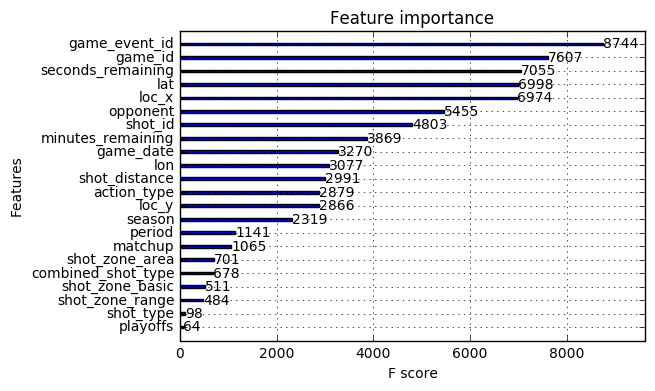

In [79]:
xgb.plot_importance(c)

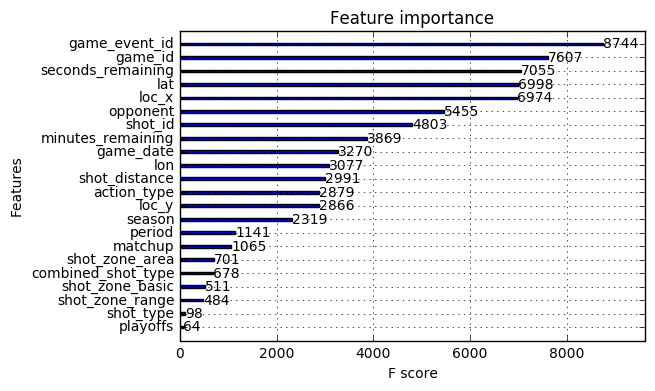

In [80]:
xgb.plot_importance(c)

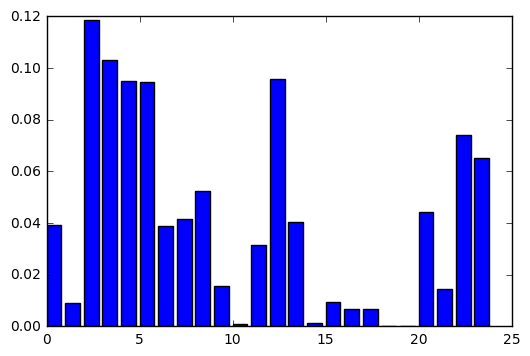

In [81]:
plt.bar(range(len(c.feature_importances_)), c.feature_importances_)
plt.show()

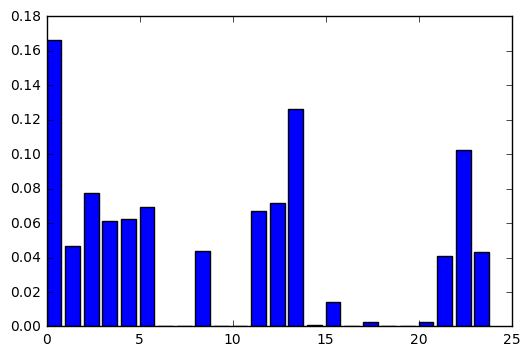

In [49]:
plt.bar(range(len(c.feature_importances_)), c.feature_importances_)
plt.show()

In [25]:
tmpdata = pd.read_csv('data.csv');
tmpdata.head(4)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
